# en-de time series forecasting example

- data : 삼성 주식 시간별 데이터
- 목적 : 시가, 하한가, 상한가를 통해 종가를 예측
- 참고자료 : https://agupubs.onlinelibrary.wiley.com/doi/pdfdirect/10.1029/2019WR025326



---

# import & read data

In [53]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, concatenate, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import RMSprop, Adam
import yfinance as yf

`-` 삼성 주식 데이터 불러오기

In [3]:
start_date = '2022-12-31'
end_date ='2024-12-31'

ticker = yf.Ticker('005930.KS')
 
df1= ticker.history(
               interval='1h',
               start=start_date,
               end=end_date,
               actions=True,
               auto_adjust=True)

In [4]:
df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-01-02 10:00:00+09:00,55500.0,56100.0,55500.0,55900.0,2981828,0.0,0.0
2023-01-02 11:00:00+09:00,55900.0,56000.0,55800.0,55900.0,1236593,0.0,0.0
2023-01-02 12:00:00+09:00,55800.0,55900.0,55500.0,55500.0,1201020,0.0,0.0
2023-01-02 13:00:00+09:00,55500.0,55700.0,55400.0,55500.0,1206452,0.0,0.0
2023-01-02 14:00:00+09:00,55400.0,55500.0,55200.0,55400.0,1855373,0.0,0.0


<Axes: xlabel='Datetime'>

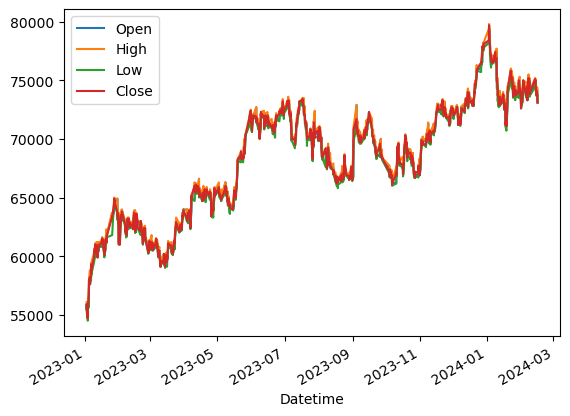

In [5]:
df1.iloc[:,:4].plot()

---

# fitting data 전처리

- 주가는 5주기를 가짐
- 인코더1 : 전날의 시가, 하한가, 상한가
- 인코더2 : 당일의 시가, 하한가, 상한가
- y : 당일의 종가

In [6]:
X = df1.iloc[:,:4].loc[:'2023-11-30 14:00:00+09:00',:]
Y = df1.iloc[:,:4].loc['2023-12-01 10:00:00+09:00':,:]


class WINdow:
    def __init__(self,df,timestep):
        self.df = df
        self.timestep=timestep+1 # 예상한 timestep보다 1적기 때문에 +1
        
    def window(self):
        for i in range(1, self.timestep):
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
            self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
        window_df = self.df.dropna(axis=0) # 결측치 공간 제거
        self.window_df = window_df.iloc[:,::-1] # 좌우 반전
        
                
        self.feature= self.window_df.iloc[:,:-1].values
        self.y_label= self.window_df.iloc[:,-1].values
        
        return self. window_df 

In [7]:
f1 = WINdow(X[['Open']],5)
f2 = WINdow(X[['High']],5)
f3 = WINdow(X[['Low']],5)
f4 = WINdow(X[['Close']],5)
f1.window()
f2.window()
f3.window()
f4.window()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6028\2080047223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6028\2080047223.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6028\2080047223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,shift_5,shift_4,shift_3,shift_2,shift_1,Close
Datetime,,,,,,
2023-01-03 09:00:00+09:00,55900.0,55900.0,55500.0,55500.0,55400.0,54700.0
2023-01-03 10:00:00+09:00,55900.0,55500.0,55500.0,55400.0,54700.0,54800.0
2023-01-03 11:00:00+09:00,55500.0,55500.0,55400.0,54700.0,54800.0,55100.0
2023-01-03 12:00:00+09:00,55500.0,55400.0,54700.0,54800.0,55100.0,55700.0
2023-01-03 13:00:00+09:00,55400.0,54700.0,54800.0,55100.0,55700.0,55600.0
...,...,...,...,...,...,...
2023-11-30 10:00:00+09:00,72600.0,72300.0,72700.0,72700.0,72400.0,72500.0
2023-11-30 11:00:00+09:00,72300.0,72700.0,72700.0,72400.0,72500.0,72600.0
2023-11-30 12:00:00+09:00,72700.0,72700.0,72400.0,72500.0,72600.0,72400.0


In [8]:
f1234= [f1.feature,f2.feature,f3.feature,f4.feature]

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
# minmax scale
f1234= [minmax.fit_transform(f1234[i]) for  i in range(len(f1234))]

# 3-dims shape 
f1234reshape = [f1234[i].reshape(-1,5,1) for i in range(len(f1234))]

# 시가
encoder_X1 = np.concatenate([f1234reshape[0],f1234reshape[1],f1234reshape[2]],axis=2)
#encoder_X2 = np.concatenate([f1234reshape[1],f1234reshape[2]],axis=2)
#encoder_X3 = np.concatenate([f1234reshape[2]],axis=2)
today_observed = encoder_X1[:,:,:][5:]
yesterday_observed = encoder_X1[:,:,:][:-5]
# 종가
y_scale = minmax.fit_transform(f4.y_label.reshape(-1, 1))
today_y = y_scale[5:]

today_observed.shape, yesterday_observed.shape ,today_y.shape

((1344, 5, 3), (1344, 5, 3), (1344, 1))

---

# target data 전처리

In [9]:
t1 = WINdow(Y[['Open']],5)
t2 = WINdow(Y[['High']],5)
t3 = WINdow(Y[['Low']],5)
t4 = WINdow(Y[['Close']],5)
t1.window()
t2.window()
t3.window()
t4.window()

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6028\2080047223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6028\2080047223.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['shift_{}'.format(i)] = self.df.iloc[:,0].shift(i)
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_6028\2080047223.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of

,shift_5,shift_4,shift_3,shift_2,shift_1,Close
Datetime,,,,,,
2023-12-04 09:00:00+09:00,72000.0,72000.0,72000.0,72000.0,72000.0,72600.0
2023-12-04 10:00:00+09:00,72000.0,72000.0,72000.0,72000.0,72600.0,72700.0
2023-12-04 11:00:00+09:00,72000.0,72000.0,72000.0,72600.0,72700.0,72600.0
2023-12-04 12:00:00+09:00,72000.0,72000.0,72600.0,72700.0,72600.0,72600.0
2023-12-04 13:00:00+09:00,72000.0,72600.0,72700.0,72600.0,72600.0,72700.0
...,...,...,...,...,...,...
2024-02-15 10:00:00+09:00,73900.0,74000.0,74100.0,74000.0,73800.0,73300.0
2024-02-15 11:00:00+09:00,74000.0,74100.0,74000.0,73800.0,73300.0,73300.0
2024-02-15 12:00:00+09:00,74100.0,74000.0,73800.0,73300.0,73300.0,73300.0


In [20]:
t1234= [t1.feature,t2.feature,t3.feature,t4.feature]

from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
# minmax scale
t1234= [minmax.fit_transform(t1234[i]) for  i in range(len(t1234))]

# 3-dims shape 
t1234reshape = [t1234[i].reshape(-1,5,1) for i in range(len(t1234))]
# 시가
target_X1 = np.concatenate([t1234reshape[0],t1234reshape[1],t1234reshape[2]],axis=2)
today_target= target_X1[5:] 
yesterday_target = target_X1[:-5] 
# 비교군
contrast= np.concatenate([t1234reshape[0],t1234reshape[1],t1234reshape[2]],axis=2)

# y
target_y_scale = minmax.fit_transform(t4.y_label.reshape(-1, 1))
target_y= target_y_scale[5:]

---

# model 생성 

`-` **논문** The rainfall‐runoff model

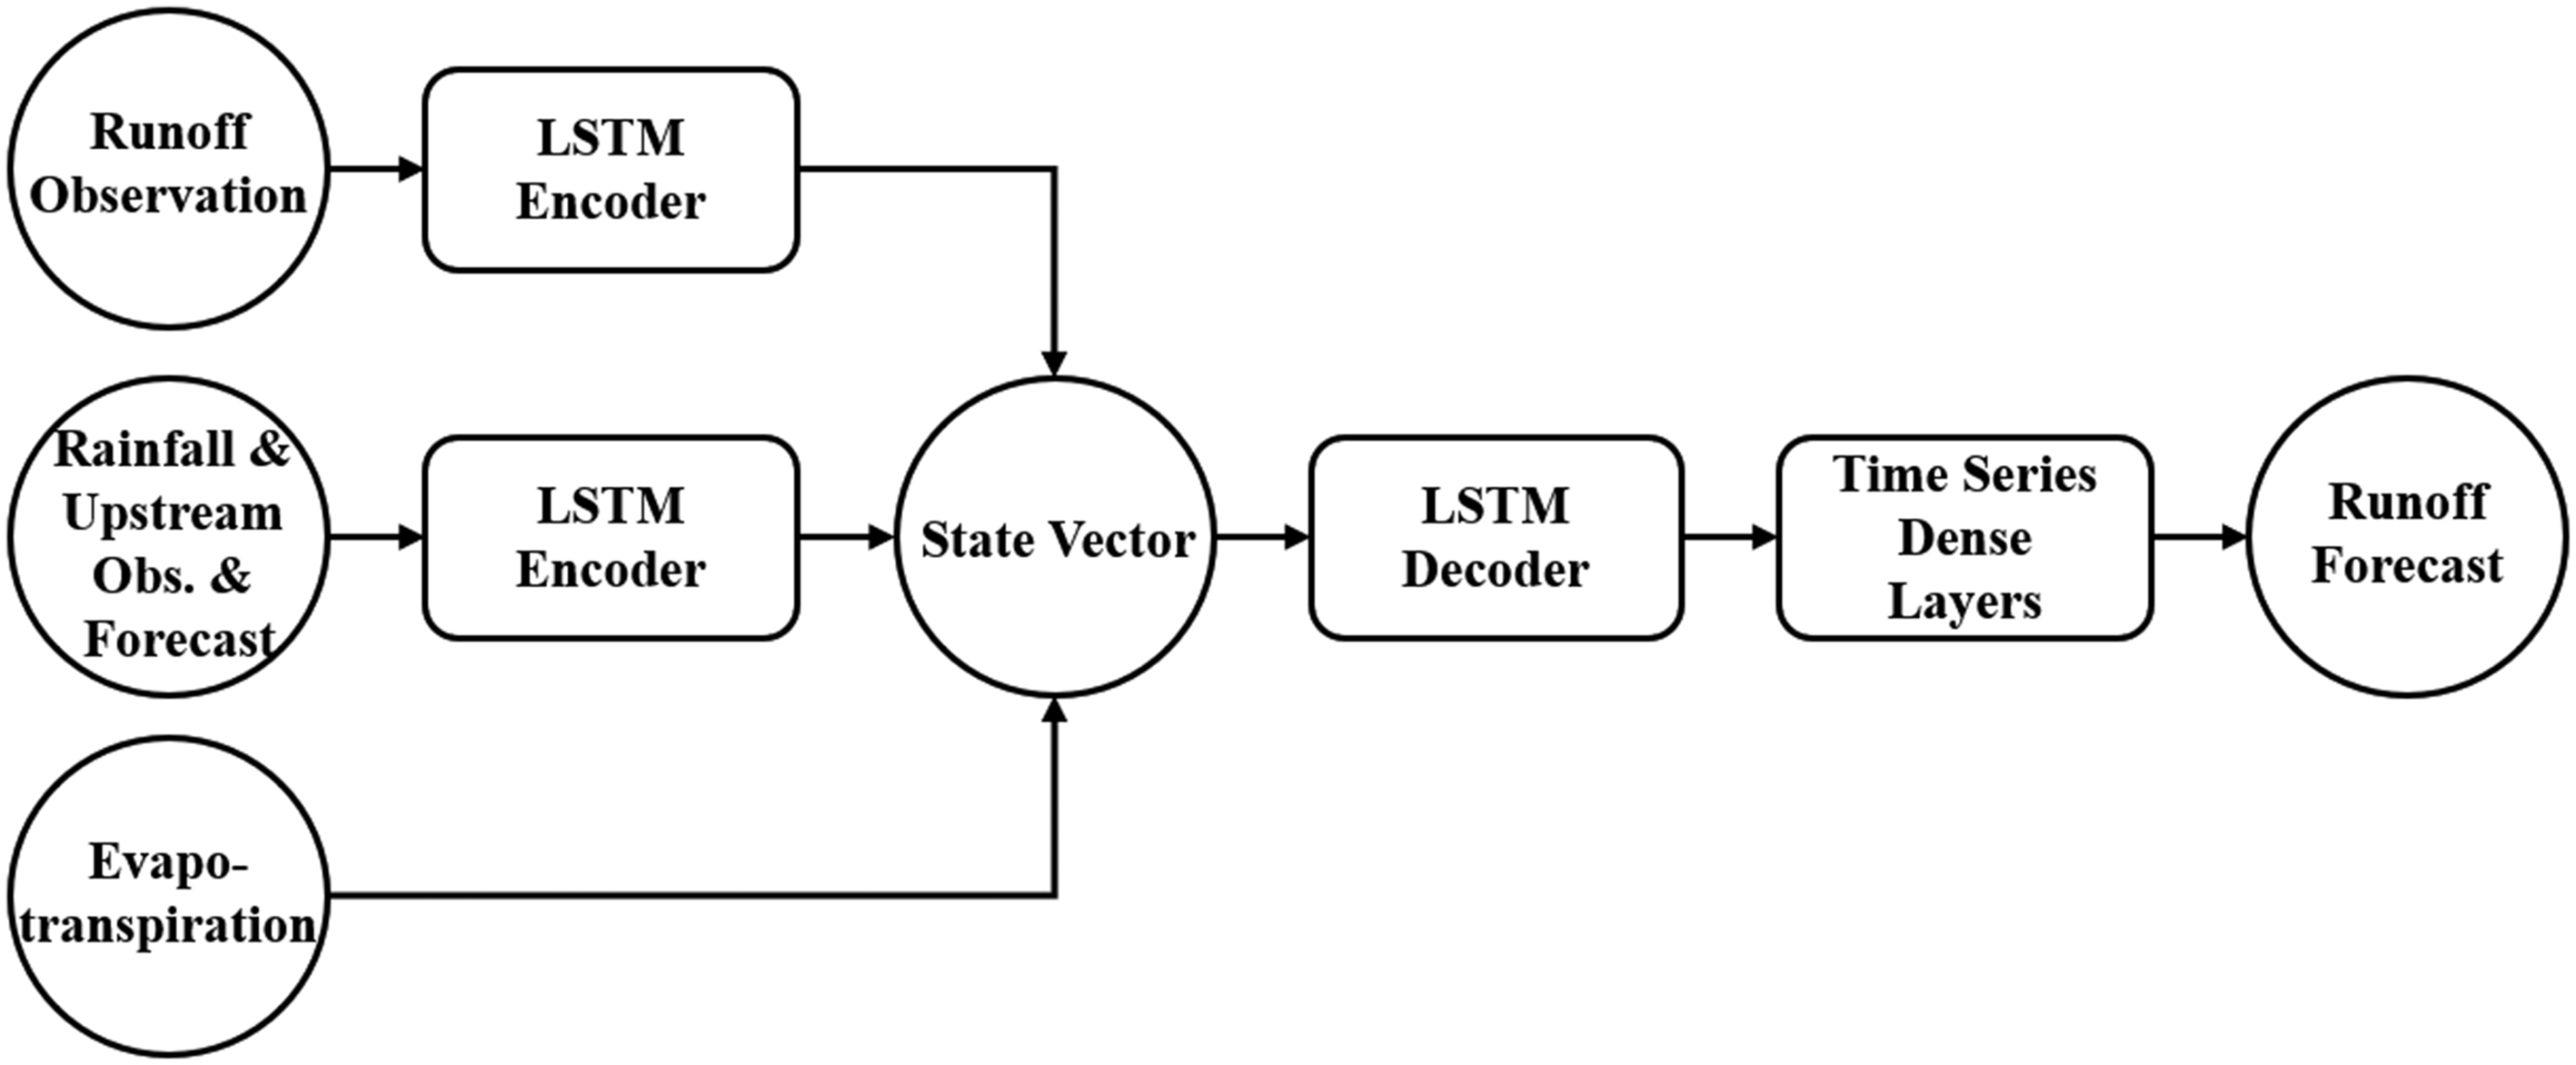

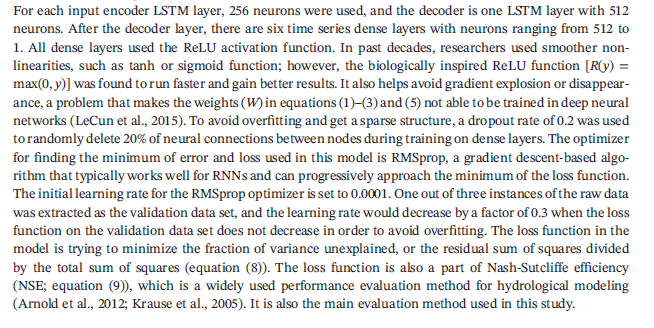

- 인코더1과 인코더2, 추가 데이터의 히든과 셀을 추출하여 디코더에게 전달
- 따라서 인코더1과 인코더2의 인풋 데이터의 feature차원은 서로 상관이 없음
- 논문을 참고하여 모델 생성
    - 각 인코더 lstm 레이어 256개 뉴런
    - 디코더 512개 뉴런
    - 디코더 레이어 이후  512 -> 1로 나아가는 6개의 밀집 레이어
        - 밀집레이어는 relu함수 사용
    - 밀집레이어 드랍아웃 0.2
    - RMSprop 초기 학습률 0.0001

---

# 주식 종가 예측 모델 구조

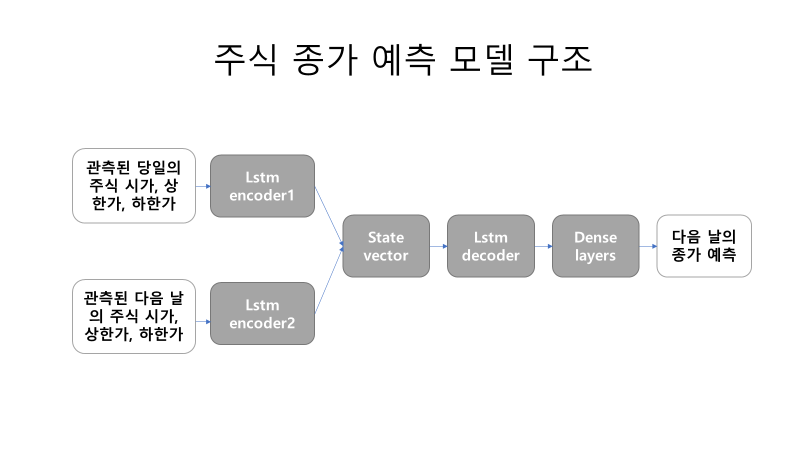

- 논문의 모델 구조를 따라가면서 인풋의 데이터는 2개로 변경
- RMSprop가 아닌 adam으로 변경(실험성능이 대체로 좋았음)
- dense layer relu -> linear로 변경
- dropout 사용하지 첫번째 dense layer에만 사용
    - 시계열데이터이고 데이터의 크기가 작음
- unit개수 전반적으로 1/2씩감소

In [271]:
n1, n2 = 128, 256
dn1,dn2,dn3,dn4,dn5,dn6 = 256,128,64,32,16,8
feature1 = 3
feature2 = 3
timestep = 5


################################################################################
# encoder1
K.clear_session()
encoder_input1 = Input(shape=( timestep , feature1))
encoder1 = LSTM(units=n1,return_state=True,name ='encoder1')
_, encoder_h1, encoder_c1 = encoder1(encoder_input1)

#################################################################################
# encoder2
encoder_input2 = Input(shape=(timestep, feature2))
encoder2 = LSTM(units=n1, return_state=True,name ='encoder2')
_, encoder_h2, encoder_c2 = encoder2(encoder_input2)

# encoder1,2의 state vector
encoder_state = concatenate([encoder_h1, encoder_c1, encoder_h2, encoder_c2], axis=-1)
################################################################################
#decoder
decoder = LSTM(units=n2,return_sequences=True,name ='decoder1')

# K.expand_dims -> data shape을 맞추기 위함
decoder_output= decoder(K.expand_dims(encoder_state, axis=1))
d1 = Dense(dn1, activation='linear')(decoder_output)
d1_d = Dropout(0.15)(d1)

d2 = Dense(dn2, activation='linear')(d1_d)
d2_d = Dropout(0.01)(d2)

d3 = Dense(dn3, activation='linear')(d2)
d3_d = Dropout(0.01)(d3)

d4 = Dense(dn4, activation='linear')(d3)
d4_d = Dropout(0.01)(d4)

d5 = Dense(dn5, activation='linear')(d4)
d5_d = Dropout(0.01)(d5)

d6 =Dense(1, activation='linear')(d5)

#decoder_outputs = Dropout(0.2)(d6)
################################################################################
#model

model = Model(inputs=[encoder_input1, encoder_input2 ], outputs=d6)
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 5, 3)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5, 3)]               0         []                            
                                                                                                  
 encoder1 (LSTM)             [(None, 128),                67584     ['input_1[0][0]']             
                              (None, 128),                                                        
                              (None, 128)]                                                        
                                                                                              

In [272]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
epochs = 50
batch_size = 2

model.fit([today_observed,yesterday_observed],today_y, epochs=epochs, batch_size=batch_size
          ,callbacks=[early_stop])


Epoch 1/50
672/672 [==============================] - 7s 5ms/step - loss: 0.0058
Epoch 2/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0022
Epoch 3/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0019
Epoch 4/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0017
Epoch 5/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0015
Epoch 6/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0013
Epoch 7/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0013
Epoch 8/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0012
Epoch 9/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 10/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0010
Epoch 11/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 12/50
672/672 [==============================] - 3s 5ms/step - loss: 0.0011
Epoch 13/50
672/672 [====

In [273]:
pred0= model.predict([today_observed,yesterday_observed])

42/42 [==============================] - 1s 2ms/step


0.0004295164215690272


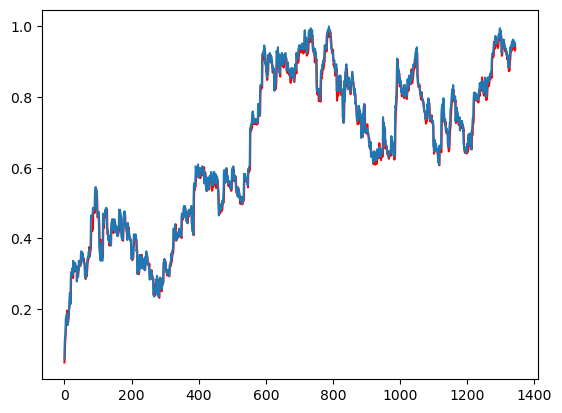

In [274]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(pred0.flatten(),today_y))
plt.plot(pred0.flatten(), color= 'red')
plt.plot(today_y)

---

`-` 비교군

In [73]:
from keras.layers import LSTM ,Dense, Bidirectional, Input, TimeDistributed
from keras.models import Sequential ,Model
from keras.callbacks import EarlyStopping
import keras.backend as K

In [167]:
# 비교군

K.clear_session()
model_no = Sequential()
model_no.add(LSTM(128, name='lstmd2',input_shape=(5,3)))
model_no.add(Dense(1))
model_no.compile(loss='mean_squared_error', optimizer='adam')

early_stop = EarlyStopping(monitor='loss', patience=10, verbose=0)
model_no.fit(encoder_X1, y_scale, epochs=50,
          batch_size=2, verbose=1, callbacks=[early_stop])

Epoch 1/30
675/675 [==============================] - 3s 2ms/step - loss: 0.0050
Epoch 2/30
675/675 [==============================] - 1s 2ms/step - loss: 0.0012
Epoch 3/30
675/675 [==============================] - 1s 2ms/step - loss: 9.3626e-04
Epoch 4/30
675/675 [==============================] - 1s 2ms/step - loss: 9.3959e-04
Epoch 5/30
675/675 [==============================] - 1s 2ms/step - loss: 8.2013e-04
Epoch 6/30
675/675 [==============================] - 1s 2ms/step - loss: 7.0290e-04
Epoch 7/30
675/675 [==============================] - 1s 2ms/step - loss: 6.6046e-04
Epoch 8/30
675/675 [==============================] - 1s 2ms/step - loss: 6.0038e-04
Epoch 9/30
675/675 [==============================] - 1s 2ms/step - loss: 5.9071e-04
Epoch 10/30
675/675 [==============================] - 1s 2ms/step - loss: 5.4304e-04
Epoch 11/30
675/675 [==============================] - 1s 2ms/step - loss: 5.3929e-04
Epoch 12/30
675/675 [==============================] - 1s 2ms/step - lo

# TEST

In [275]:
pred1= model.predict([today_target, yesterday_target])
pred2= model_no.predict(today_target)

9/9 [==============================] - 0s 1ms/step


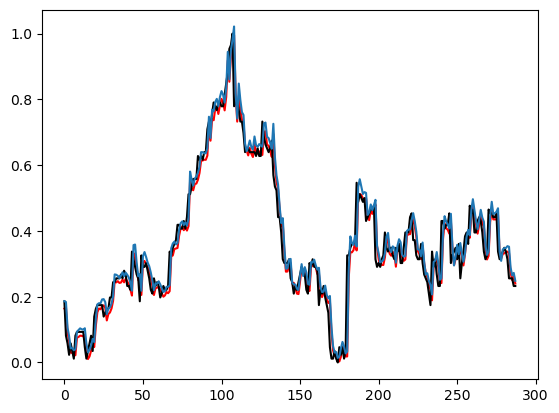

In [276]:
plt.plot(pred1.flatten(),color='red')
plt.plot(target_y,color='black')
plt.plot(pred2.flatten())

In [277]:
from sklearn.metrics import mean_squared_error

print('en-de lstm ',mean_squared_error(target_y,pred1.flatten()))
print('normal lstm',mean_squared_error(target_y,pred2.flatten()))

en-de lstm  0.002599030235042551
normal lstm 0.002824254216755877
